_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [157]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install matplotlib==3.7.1
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`).

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [158]:
# YOUR CODE HERE
import category_encoders as ce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdpbox import pdp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [159]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url)
# YOUR CODE HERE
#ensure 'inspection Date' is datetime
df['Inspection Date']=pd.to_datetime(df['Inspection Date'])
df['Inspection Year'] = df['Inspection Date'].dt.year
df.set_index('Inspection Date',inplace= True)
#Drop Inspection date column
#df=df.drop(columns=['Inspection Date'])
#Define target columns as a list of strings
df.head()
df.columns


Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Type',
       'Violations', 'Latitude', 'Longitude', 'Location', 'Fail',
       'Serious Violations Found', 'Inspection Year'],
      dtype='object')

**Task 1 Test**

In [160]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [161]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'
# YOUR CODE HERE


**Task 2 Test**

In [162]:
'''T2 Test'''
# This is a hidden test.
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [163]:
'''T3. Write wrangle function.'''
def wrangle(df):
 #Removes the "leaky" column.
  if 'Serious Violations Found' in df.columns:
   df= df.drop(columns=['Serious Violations Found','License #'])

#Remove high Cardinality columns(more than 500 unique values)
  for col in df.select_dtypes('object'):
        if df[col].nunique() > 500:
            df= df.drop(columns=col)
#Removes categorical columns that have only one category.
  for col in df.select_dtypes('object'):
        if df[col].nunique() ==1:
          df=df.drop(columns=col)

#Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.
  for col in df.select_dtypes(include=['int64', 'float64']):
    if df[col].nunique()==len(df) and col != 'Inspection Year':
      df=df.drop(columns=col)


  return df
# YOUR CODE HERE

df = wrangle(df)
#Display the first  few rows of the processed datafrom:
df.head()
df.columns

Index(['Facility Type', 'Risk', 'City', 'Zip', 'Inspection Type', 'Latitude',
       'Longitude', 'Fail', 'Inspection Year'],
      dtype='object')

**Task 3 Test**

In [164]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

In [165]:
df.columns

Index(['Facility Type', 'Risk', 'City', 'Zip', 'Inspection Type', 'Latitude',
       'Longitude', 'Fail', 'Inspection Year'],
      dtype='object')

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [166]:
'''T4. Split feature matrix and target vector.'''

target = 'Fail'
#YOUR CODE HERE
X=df.drop(columns=[target])
y=df[target]
df.columns

Index(['Facility Type', 'Risk', 'City', 'Zip', 'Inspection Type', 'Latitude',
       'Longitude', 'Fail', 'Inspection Year'],
      dtype='object')

**Task 4 Test**

In [167]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [168]:
'''T5. Split dataset into training and validation sets.'''

# YOUR CODE HERE

train_mask=df['Inspection Year']<2017
val_mask=df['Inspection Year']>=2017
X_train=X[train_mask]
y_train=y[train_mask]
X_val=X[val_mask]
y_val=y[val_mask]
print(X_train.head())

                  Facility Type             Risk     City      Zip  \
Inspection Date                                                      
2011-10-20        Grocery Store     Risk 3 (Low)  CHICAGO  60636.0   
2016-04-05           Restaurant    Risk 1 (High)  CHICAGO  60649.0   
2016-04-29           Restaurant  Risk 2 (Medium)  CHICAGO  60632.0   
2011-01-10               School    Risk 1 (High)  CHICAGO  60629.0   
2016-02-22       Long Term Care    Risk 1 (High)  CHICAGO  60614.0   

                         Inspection Type   Latitude  Longitude  \
Inspection Date                                                  
2011-10-20       Complaint Re-Inspection  41.772402 -87.683603   
2016-04-05         Canvass Re-Inspection  41.758779 -87.575054   
2016-04-29                       Canvass  41.812181 -87.707125   
2011-01-10                       Canvass        NaN        NaN   
2016-02-22                       Canvass  41.932632 -87.647973   

                 Inspection Year  
Inspection 

**Task 5 Testing**

In [169]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [170]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


In [171]:
#check the dtype for the training set
print(X_train.dtypes)

Facility Type       object
Risk                object
City                object
Zip                float64
Inspection Type     object
Latitude           float64
Longitude          float64
Inspection Year      int32
dtype: object


**Task 6 Testing**

In [172]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [173]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE

model_bag= make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier( n_estimators=100,random_state=42, n_jobs=-1)

)


model_bag.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Facility Type', 'Risk', 'City',
                                      'Inspection Type'],
                                mapping=[{'col': 'Facility Type',
                                          'data_type': dtype('O'),
                                          'mapping': Grocery Store                                        1
Restaurant                                           2
School                                               3
Long Term Care                                       4
Liquor                                               5
                                                  ... 
COFFEE  SHOP                                       301
MOBILE FROZEN DESSERTS DISPENSER-NON- MOTORIZED    302
(convenience store)                                303
RESTAURANT/BAR/THEATER                             304
NaN                                                305
Length: 305, dtype: in...
CANVASS/SPECIAL EVENT                     40
RECALL INSPECTION                         41
POSSIBLE FBI                              42
License consultation                      43
SPECIAL TASK FORCE                        44
SFP/Complaint                             45
LICENSE DAYCARE 1586                      46
license                                   47
LICENSE REQUEST                           48
ADDENDUM                                  49
SFP/COMPLAINT                             50
REINSPECTION OF 48 HOUR NOTICE            51
NaN                                       52
dtype: int64}])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

**Tast 7 Testing**

In [174]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary.

In [175]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost= make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    xgb.XGBClassifier(n_estimators=100,random_state=42, n_jobs=-1 )
)
model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [176]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

In [177]:
print(X_train.head())

                  Facility Type             Risk     City      Zip  \
Inspection Date                                                      
2011-10-20        Grocery Store     Risk 3 (Low)  CHICAGO  60636.0   
2016-04-05           Restaurant    Risk 1 (High)  CHICAGO  60649.0   
2016-04-29           Restaurant  Risk 2 (Medium)  CHICAGO  60632.0   
2011-01-10               School    Risk 1 (High)  CHICAGO  60629.0   
2016-02-22       Long Term Care    Risk 1 (High)  CHICAGO  60614.0   

                         Inspection Type   Latitude  Longitude  \
Inspection Date                                                  
2011-10-20       Complaint Re-Inspection  41.772402 -87.683603   
2016-04-05         Canvass Re-Inspection  41.758779 -87.575054   
2016-04-29                       Canvass  41.812181 -87.707125   
2011-01-10                       Canvass        NaN        NaN   
2016-02-22                       Canvass  41.932632 -87.647973   

                 Inspection Year  
Inspection 

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [178]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9779807301503813
Validation accuracy: 0.6749925661611657

Boosting Model
Training accuracy: 0.8025916274176967
Validation accuracy: 0.6925364258102884


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

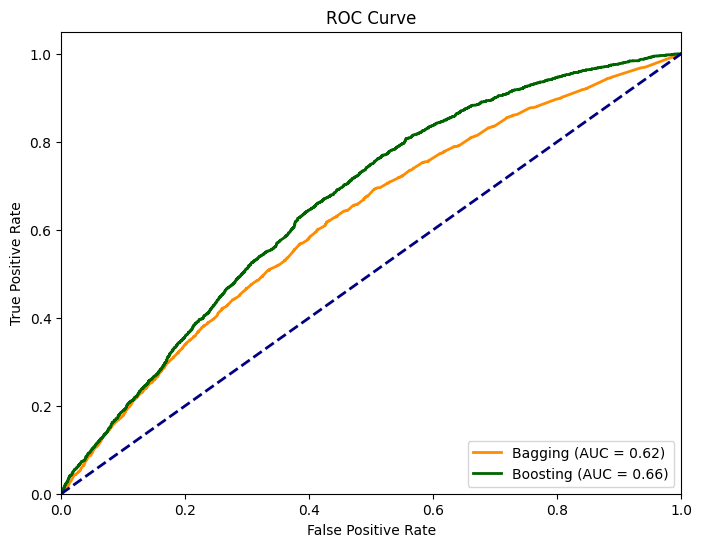

In [179]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (Fail)
y_pred_prob_bag = model_bag.predict_proba(X_val)[:, 1]
y_pred_prob_boost = model_boost.predict_proba(X_val)[:, 1]

# Calculate ROC curve and AUC for bagging model
fpr_bag, tpr_bag, thresholds_bag = roc_curve(y_val, y_pred_prob_bag)
roc_auc_bag = auc(fpr_bag, tpr_bag)

# Calculate ROC curve and AUC for boosting model
fpr_boost, tpr_boost, thresholds_boost = roc_curve(y_val, y_pred_prob_boost)
roc_auc_boost = auc(fpr_boost, tpr_boost)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_bag, tpr_bag, color='darkorange', lw=2, label=f'Bagging (AUC = {roc_auc_bag:.2f})')
plt.plot(fpr_boost, tpr_boost, color='darkgreen', lw=2, label=f'Boosting (AUC = {roc_auc_boost:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`.

In [180]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE
# Choose the boosting model based on the ROC curve analysis
model_cr = classification_report(y_val, model_boost.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      7092
           1       0.45      0.14      0.22      2997

    accuracy                           0.69     10089
   macro avg       0.58      0.53      0.51     10089
weighted avg       0.64      0.69      0.63     10089



**Task 10 Testing**

In [181]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [185]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
from sklearn.inspection import permutation_importance

# Replace with your desired feature names if 'License', 'BuildingType', 'ExterQual' are not the intended features
features_for_importance = [ 'Zip','Facility Type', 'Risk', 'City', 'Inspection Type', 'Latitude', 'Longitude']
# Get the feature names the model was trained on
#model_features = model_boost.feature_names_in_
try:
    model_features = model_boost.feature_names_in_
except AttributeError:
    model_features = X_val.columns
# Ensure features_for_importance are a subset of model_features
features_for_importance = [f for f in features_for_importance if f in model_features]

result = permutation_importance(
    model_boost, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
)
permutation_importances = pd.DataFrame(
    {
        "mean": result.importances_mean,
        "std": result.importances_std,
    },
    index=model_features,
)
# Filter the DataFrame to show only the features you are interested in
permutation_importances = permutation_importances.loc[features_for_importance]

print(permutation_importances)
print("Actual shape of permutation_importances:", permutation_importances.shape)





                     mean       std
Zip             -0.006462  0.001630
Facility Type    0.001863  0.001236
Risk             0.000704  0.001242
City            -0.000059  0.000173
Inspection Type  0.019487  0.002974
Latitude        -0.000109  0.001805
Longitude        0.002379  0.001557
Actual shape of permutation_importances: (7, 2)


**Task 11 Testing**

In [186]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

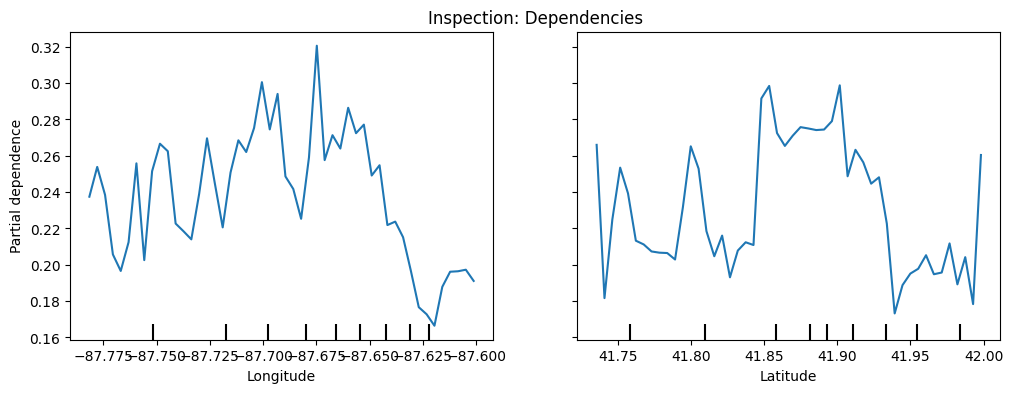

TypeError: PDPIsolate.__init__() missing 1 required positional argument: 'feature_name'

In [184]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''

# YOUR CODE HERE
!pip install pdpbox
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,4))
display = PartialDependenceDisplay.from_estimator(
    model_boost,feature_names=X_val.columns,
    features = ['Longitude', 'Latitude'],
    X=X_val, grid_resolution=50, ax=ax);

ax.set_title('Inspection: Dependencies')
plt.show()

# Create the PDP interaction plot
from pdpbox.pdp import PDPIsolate, PDPInteract
from pdpbox.info_plots import TargetPlot, InteractTargetPlot
isolated = PDPIsolate(
    model=model_boost,
    df=X_val,
    model_features=X_val.columns,
    feature='Longitude'
)



What do you think? Is there a relationship between location and failing a food saftey inspection? Answer below.

This task will not be autograded - but it is part of completing the challenge.